<a href="https://colab.research.google.com/github/HanselWilfred/WeatherWise-Hansel-Wilfred/blob/main/starter_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 🧪 Optional packages — uncomment if needed in Colab or JupyterHub
!pip install fetch-my-weather
!pip install requests matplotlib pyinputplus





  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyinputplus: filename=pyinputplus-0.2.12-py3-none-any.whl size=11348 sha256=a592ead02c64bf06bea0b9c7d2f5e3d56a65315308be763b400678b810db37e1
  Stored in directory: /root/.cache/pip/wheels/85/81/c1/325c8199c5c4de8a0b9af900ff9cd8bd69853e3d9419493512
  Created wheel for pysimplevalidate: filename=pysimplevalidate-0.2.12-py3-none-any.whl size=16225 sha256=f66ddf94fee36c56233ea169dd29e2bb31dc88181eca3ab3633b74d84581396e
  Stored in directory: /root/.cache/pip/wheels/09/de/18/4dd2be0dbdf31870c6f0abde43b0de197b1c095655ad7da5c2
  Created wheel for stdiomask: filename=stdiomask

## 📦 Setup and Configuration
Import required packages and setup environment.

In [2]:
import requests
import matplotlib.pyplot as plt
import pyinputplus as pyip
# ✅ Import after installing (if needed)
from fetch_my_weather import get_weather

# Add any other setup code here

## 🌤️ Weather Data Functions

In [3]:
# ==== WeatherWise: Assignment-Style Implementations (Colab) ====
from typing import Optional, Dict, Any
import re, requests
from datetime import datetime

# -- tiny helpers --
def _fmt_date(d: str) -> str:
    try: return datetime.strptime(d, "%Y-%m-%d").strftime("%d %b %Y")
    except Exception: return d

def _emoji_for_temp(t: Optional[float]) -> str:
    try: t = float(t)
    except (TypeError, ValueError): return ""
    return "🔥" if t >= 35 else ("🙂" if t >= 15 else "🥶")

# 1) Data Fetching
def get_weather_data(location: str, forecast_days: int = 5) -> Dict[str, Any]:
    """Return {'location','current_temp','forecast':[{'date','max_temp','min_temp','rain_chance'},...]}; {} on error."""
    try:
        days = max(1, min(5, int(forecast_days or 5)))
    except Exception:
        days = 5
    if not location: return {}
    loc = re.sub(r"\b(tomorrow|today|day after|in\s+\d+\s+days)\b", "", str(location), flags=re.I)
    loc = re.sub(r"\s+", " ", loc).strip()
    if not loc: return {}
    try:
        g = requests.get("https://geocoding-api.open-meteo.com/v1/search",
                         params={"name": loc, "count": 1, "language": "en"}, timeout=10)
        g.raise_for_status()
        hits = (g.json().get("results") or [])
        if not hits: return {}
        lat, lon = hits[0]["latitude"], hits[0]["longitude"]
        city = hits[0].get("name") or loc
        f = requests.get("https://api.open-meteo.com/v1/forecast",
                         params={"latitude": lat, "longitude": lon, "timezone": "auto",
                                 "current_weather": True,
                                 "daily": "temperature_2m_max,temperature_2m_min,precipitation_probability_max"},
                         timeout=10)
        f.raise_for_status()
        data = f.json()
        daily = data.get("daily") or {}
        dates = daily.get("time") or []
        if not dates: return {}
        tmax = daily.get("temperature_2m_max") or []
        tmin = daily.get("temperature_2m_min") or []
        rain = daily.get("precipitation_probability_max") or []
        n = min(days, len(dates))
        fc = []
        for i in range(n):
            fc.append({
                "date": dates[i],
                "max_temp": tmax[i] if i < len(tmax) else None,
                "min_temp": tmin[i] if i < len(tmin) else None,
                "rain_chance": rain[i] if i < len(rain) else None,
            })
        return {"location": city,
                "current_temp": (data.get("current_weather") or {}).get("temperature"),
                "forecast": fc}
    except requests.RequestException:
        return {}





## 📊 Visualisation Functions

In [8]:
# 1

def create_temperature_visualisation(weather_data: dict, output_type: str = 'display'):
    """
    GUI-style temperature visualisation:
      - Top info bar: city, current temp, min–max today + emoji
      - Main chart : 5-day min–max band + min/max lines
    """
    if not weather_data or not weather_data.get("forecast"):
        print("No data to visualise."); return None

    try:
        import matplotlib.pyplot as plt
        from matplotlib.gridspec import GridSpec
    except Exception:
        print("📉 Matplotlib not available."); return None

    fc = weather_data["forecast"]
    xs = list(range(len(fc)))

    # date labels
    from datetime import datetime
    def _fmt(d):
        try: return datetime.strptime(d, "%Y-%m-%d").strftime("%d %b %Y")
        except: return d
    dates = [_fmt(r["date"]) for r in fc]

    # temps
    tmin = [r.get("min_temp") for r in fc]
    tmax = [r.get("max_temp") for r in fc]

    # pick emoji for the day using max temp (fallback min)
    def _emoji(val):
        try:
            val = float(val)
        except (TypeError, ValueError):
            return ""
        return "🔥" if val >= 35 else ("🙂" if val >= 15 else "🥶")
    today_emoji = _emoji(tmax[0] if tmax and tmax[0] is not None else tmin[0])

    # figure layout
    fig = plt.figure(figsize=(10, 6))
    gs = GridSpec(3, 1, height_ratios=[1, 0.2, 3], hspace=0.15)

    # --- Top "GUI" info bar ---
    ax_top = fig.add_subplot(gs[0, 0])
    ax_top.axis("off")
    city = weather_data.get("location", "Location")
    cur  = weather_data.get("current_temp", "N/A")
    # today's min/max if present
    tmin0 = tmin[0] if tmin and tmin[0] is not None else "—"
    tmax0 = tmax[0] if tmax and tmax[0] is not None else "—"

    title = f"{city}"
    sub_a = f"Now: {cur}°C"
    sub_b = f"Today: {tmin0}–{tmax0}°C"
    ax_top.text(0.01, 0.65, title, fontsize=18, weight="bold")
    ax_top.text(0.01, 0.30, f"{sub_a}   |   {sub_b}   {today_emoji}", fontsize=12)

    # subtle divider line
    ax_div = fig.add_subplot(gs[1, 0])
    ax_div.set_ylim(0,1); ax_div.set_xlim(0,1)
    ax_div.axhline(0.5, color="0.8")
    ax_div.axis("off")

    # --- Main temperature chart ---
    ax = fig.add_subplot(gs[2, 0])
    ax.fill_between(xs, tmin, tmax, alpha=0.25, label="Daily range")
    ax.plot(xs, tmax, marker="o", label="Max (°C)")
    ax.plot(xs, tmin, marker="o", label="Min (°C)")

    # emoji tags above daily max
    for x, mx in enumerate(tmax):
        y = mx if isinstance(mx, (int, float, float)) else (tmin[x] if x < len(tmin) else None)
        tag = _emoji(mx if mx is not None else tmin[x])
        if y is not None and tag:
            ax.text(x, y + 0.6, tag, ha="center", va="bottom", fontsize=11)

    ax.set_title("Temperature (Min–Max) — Next Days")
    ax.set_ylabel("°C"); ax.set_xlabel("Day")
    ax.set_xticks(xs); ax.set_xticklabels(dates)
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend()
    plt.tight_layout()

    if output_type == 'figure': return fig
    plt.show(); return None



In [9]:
   # 2
   def create_precipitation_visualisation(weather_data: dict, output_type: str = 'display'):
    """
    Raincloud-style visualisation for rain chance (per day):
      - Soft cloud-like fill (area under % line)
      - Line over the fill
      - Stems + 'raindrop' dots with % labels
    """
    if not weather_data or not weather_data.get("forecast"):
        print("No data to visualise."); return None

    try:
        import matplotlib.pyplot as plt
    except Exception:
        print("📉 Matplotlib not available."); return None

    fc = weather_data["forecast"]
    xs = list(range(len(fc)))

    # date labels
    from datetime import datetime
    def _fmt(d):
        try: return datetime.strptime(d, "%Y-%m-%d").strftime("%d %b %Y")
        except: return d
    dates = [_fmt(r["date"]) for r in fc]

    # clamp rain to 0..100
    rain = []
    for r in fc:
        v = r.get("rain_chance")
        try: v = float(v)
        except (TypeError, ValueError): v = 0.0
        rain.append(max(0.0, min(100.0, v)))

    fig = plt.figure(figsize=(10, 4.8))
    ax = plt.gca()

    # "cloud" fill + line
    ax.fill_between(xs, [0]*len(xs), rain, alpha=0.18)     # soft cloud
    ax.plot(xs, rain, marker=None, linewidth=2)            # outline

    # stems + raindrops + labels
    for x, v in zip(xs, rain):
        ax.vlines(x, 0, v, linewidth=2)                    # stem
        ax.scatter(x, v, s=90, zorder=3)                   # drop head
        ax.text(x, v + 2, f"{int(v)}%", ha="center", fontsize=9)

    ax.set_title(f"Rain Chance — {weather_data.get('location','Location')}")
    ax.set_ylabel("Rain Chance (%)"); ax.set_xlabel("Day")
    ax.set_ylim(0, 100)
    ax.set_xticks(xs); ax.set_xticklabels(dates)
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()

    if output_type == 'figure': return fig
    plt.show(); return None






## 🤖 Natural Language Processing

In [10]:
# === Section 2: NLP + Response (with formatted dates) ===
import re
from typing import Optional
from datetime import datetime

# ---- tiny helpers ----
def format_date(d: str) -> str:
    """'YYYY-MM-DD' -> 'DD Mon YYYY' (fallback to original if parsing fails)."""
    try:
        return datetime.strptime(d, "%Y-%m-%d").strftime("%d %b %Y")
    except Exception:
        return d

def _as_float(x):
    """Safely convert to float; return None if not possible."""
    try:
        return float(x)
    except (TypeError, ValueError):
        return None

def _clean_location(text: str) -> Optional[str]:
    """Remove time words and extra spaces so geocoder sees only the place."""
    if not text:
        return None
    text = re.sub(r"\b(tomorrow|today|day after tomorrow|day after|in\s+\d+\s+day[s]?)\b", "", text, flags=re.I)
    text = re.sub(r"\s+", " ", text).strip()
    return text.title() if text else None

# ---- parsing ----
def parse_weather_question(q: str):
    """
    Returns: {"location": str|None, "day": 0..4, "attribute": "rain"|"temperature"|"general"}
    """
    q = (q or "").lower().strip()

    # Day: today=0, tomorrow=1, day after=2, or "in N day(s)" clamped 0..4
    if "day after tomorrow" in q or "day after" in q:
        day = 2
    elif "tomorrow" in q:
        day = 1
    else:
        day = 0
    m = re.search(r"\bin\s+(\d+)\s+day(s)?\b", q)
    if m:
        try:
            day = max(0, min(4, int(m.group(1))))
        except Exception:
            pass

    # Attribute intent
    if any(w in q for w in ["rain", "rainy", "umbrella", "drizzle", "shower", "showers"]):
        attr = "rain"
    elif any(w in q for w in ["temp", "temperature", "hot", "cold", "warm", "cool", "chill"]):
        attr = "temperature"
    else:
        attr = "general"

    # Location: PIN/ZIP first
    pin = re.search(r"\b\d{3,6}\b", q)
    if pin:
        return {"location": pin.group(0), "day": day, "attribute": attr}

    # Or words after "in ..." (stop before punctuation/time words)
    m = re.search(
        r"\bin\s+([a-z0-9\s\-]+?)(?=(?:\?|\.|,|$|\s+tomorrow|\s+today|\s+day after(?:\s+tomorrow)?|\s+in\s+\d+\s+day[s]?))",
        q
    )
    loc = _clean_location(m.group(1)) if m else None
    return {"location": loc, "day": day, "attribute": attr}

# ---- response generation ----
def generate_weather_response(user_question: str, fetch_fn):
    """
    fetch_fn(place) -> {"error": "..."} OR {"location": str, "forecast": [{date,max_temp,min_temp,rain_chance}, ...]}
    Returns a short natural-language sentence tailored to rain / temperature / general.
    """
    info = parse_weather_question(user_question)
    place, day, attr = info["location"], info["day"], info["attribute"]

    if not place:
        return "Please tell me a city or PIN/ZIP (e.g., 'weather in Perth')."

    data = fetch_fn(place)
    if not data or "error" in data:
        return data.get("error", "Sorry, I couldn't get the weather right now.")

    fc = data.get("forecast") or []
    if not fc:
        return "No forecast available right now."

    # Choose the requested day (clamped)
    i = min(day, len(fc) - 1)
    row = fc[i]
    city = data.get("location", place)
    date = format_date(row.get("date", "that day"))

    mx, mn = row.get("max_temp"), row.get("min_temp")
    rc = _as_float(row.get("rain_chance"))
    t = mx if mx is not None else mn

    # 35+ hot, 15..34 cool, <15 cold
    def temp_phrase(x):
        if x is None:
            return "temperature unavailable"
        return "hot and sunny" if x >= 35 else ("cool and pleasant" if x >= 15 else "cold")

    def rain_only(v):
        if v is None:
            return "No rain info."
        return ("Yes, likely — rain %d%%." % int(v)) if v >= 50 else \
               ("Possible — rain %d%%." % int(v)) if v >= 20 else \
               ("Unlikely — rain %d%%." % int(v))

    # Intent-specific replies
    if attr == "rain":
        return f"In {city} on {date}: {rain_only(rc)}"

    # temperature / general
    msg = f"In {city} on {date}: {temp_phrase(t)}"
    if t is not None:
        msg += f" (around {round(t)}°C)"
    if rc is not None and rc >= 30:
        # Only mention rain if it's notable
        msg += f", rain {int(rc)}%."
    else:
        msg += "."
    return msg




## 🧭 User Interface

In [11]:
# === UI (A): helpers & visualisations ===

def print_forecast(result: dict):
    if not result or "error" in result:
        print(f"⚠️ {result.get('error','No data')}")
        return

    cur = result.get('current_temp')
    cur_txt = f"{cur}°C" if isinstance(cur, (int, float)) else "N/A"
    print(f"📍 {result['location']} | 🌡️ {cur_txt}")

    for f in result.get("forecast", []):
        # formatted date
        fd = format_date(f.get('date', ''))
        # pick temp + emoji
        pick = f.get("max_temp")
        if pick is None: pick = f.get("min_temp")
        emoji = "🔥" if (isinstance(pick, (int, float)) and pick >= 35) else \
                ("🙂" if (isinstance(pick, (int, float)) and pick >= 15) else "🥶")

        # temp string
        if isinstance(f.get("min_temp"), (int, float)) and isinstance(f.get("max_temp"), (int, float)):
            temp_txt = f"{f['min_temp']:.1f}–{f['max_temp']:.1f}°C"
        elif isinstance(f.get("max_temp"), (int, float)):
            temp_txt = f"{f['max_temp']:.1f}°C"
        elif isinstance(f.get("min_temp"), (int, float)):
            temp_txt = f"{f['min_temp']:.1f}°C"
        else:
            temp_txt = "temp N/A"

        # optional rain note (only if meaningful ≥30%)
        rc = f.get("rain_chance")
        try:
            rcv = float(rc)
        except (TypeError, ValueError):
            rcv = None
        rain_note = f" (rain {int(rcv)}%)" if (rcv is not None and rcv >= 30) else ""

        print(f"{fd}: {temp_txt} {emoji}{rain_note}")

def create_temperature_visualisation(result: dict):
    """Shaded min–max band + lines."""
    if not result or "error" in result or not result.get("forecast"):
        print("No data to visualise."); return
    try:
        import matplotlib.pyplot as plt
    except Exception:
        print("📉 Matplotlib not available."); return

    fc = result["forecast"]
    xs = list(range(len(fc)))
    dates = [format_date(r.get("date","")) for r in fc]
    tmin  = [r.get("min_temp") for r in fc]
    tmax  = [r.get("max_temp") for r in fc]

    plt.figure(figsize=(8,4.5))
    plt.fill_between(xs, tmin, tmax, alpha=0.25, label="Daily range")
    plt.plot(xs, tmax, marker="o", label="Max (°C)")
    plt.plot(xs, tmin, marker="o", label="Min (°C)")
    plt.title(f"Temperature (Min–Max) — {result.get('location','Location')}")
    plt.xlabel("Day"); plt.ylabel("°C"); plt.xticks(xs, dates)
    plt.grid(True, linestyle="--", alpha=0.5); plt.legend(); plt.tight_layout(); plt.show()

def create_precipitation_visualisation(result: dict):
    """Rain chance raincloud-like (stems + dots + % labels)."""
    if not result or "error" in result or not result.get("forecast"):
        print("No data to visualise."); return
    try:
        import matplotlib.pyplot as plt
    except Exception:
        print("📉 Matplotlib not available."); return

    fc = result["forecast"]
    xs = list(range(len(fc)))
    dates = [format_date(r.get("date","")) for r in fc]

    rainp = []
    for r in fc:
        v = r.get("rain_chance")
        try:
            v = float(v)
        except (TypeError, ValueError):
            v = 0.0
        rainp.append(max(0.0, min(100.0, v)))

    plt.figure(figsize=(8,4.5))
    # soft fill + line for a raincloud vibe
    import numpy as np
    plt.fill_between(xs, np.zeros(len(xs)), rainp, alpha=0.15)
    plt.plot(xs, rainp, linewidth=2)

    for x, v in zip(xs, rainp):
        plt.vlines(x, 0, v, linewidth=2)
        plt.scatter(x, v, s=60, zorder=3)
        plt.text(x, v + 2, f"{int(v)}%", ha="center", fontsize=8)

    plt.title(f"Rain Chance — {result.get('location','Location')}")
    plt.xlabel("Day"); plt.ylabel("Rain Chance (%)"); plt.xticks(xs, dates)
    plt.ylim(0, 100); plt.grid(axis="y", linestyle="--", alpha=0.5); plt.tight_layout(); plt.show()

def create_both_visualisations(result: dict):
    """Show temperature chart, then rain chart."""
    create_temperature_visualisation(result)
    create_precipitation_visualisation(result)





In [12]:
# === UI (B): main menu loop ===

def run_app():
    print("🌦️ Welcome to WeatherWise 🌦️")
    print("👉 You can enter either a city name OR a PIN/ZIP code.")
    while True:
        print("\nPlease select one of the following:")
        print("1. View Forecast")
        print("2. Ask a Question")
        print("3. Visualise Data")
        print("4. Exit")
        choice = input("> ").strip()

        if choice == "1":
            # View Forecast
            place = input("Enter a city or PIN/ZIP: ").strip()
            result = get_weather_data(place)
            print_forecast(result)

        elif choice == "2":
            # Ask a Question (don’t ask for city again if already inside the question)
            q = input("Ask about the weather: ").strip()  # e.g., "Will it rain tomorrow in Adelaide?"

            info = parse_weather_question(q)
            place = info.get("location")

            if not place:
                # Only ask if the parser didn't find a location
                place = input("City or PIN/ZIP: ").strip()
                q_full = f"{q} in {place}"
            else:
                q_full = q  # already contains a location

            print(generate_weather_response(q_full, get_weather_data))

        elif choice == "3":
            # Visualise Data
            place = input("Enter a city to visualise: ").strip()
            result = get_weather_data(place)
            if not result or "error" in result:
                print(f"⚠️ {result.get('error','No data')}")
                continue

            # Offer Dashboard only if it's defined in your notebook
            has_dashboard = 'create_dashboard_visualisation' in globals()

            if has_dashboard:
                print("Visualise: 1) Temperature  2) Rain  3) Both  4) Dashboard")
            else:
                print("Visualise: 1) Temperature  2) Rain  3) Both")

            v = input("> ").strip().lower()

            if v in ("1", "temp", "temperature"):
                create_temperature_visualisation(result)
            elif v in ("2", "rain", "precip", "precipitation"):
                create_precipitation_visualisation(result)
            elif v in ("3", "both", "all"):
                try:
                    create_both_visualisations(result)
                except NameError:
                    # fallback if helper not defined
                    create_temperature_visualisation(result)
                    create_precipitation_visualisation(result)
            elif v in ("4", "dash", "dashboard") and has_dashboard:
                create_dashboard_visualisation(result)
            else:
                print("Choose a valid option.")

        elif choice == "4":
            print("Goodbye! ☀️")
            break

        else:
            print("Please choose 1–4.")




## 🧩 Main Application Logic

In [13]:
# Tie everything together here
def run_app():
    print("🌦️ Welcome to WeatherWise 🌦️")
    print("👉 Enter a city (Perth) or PIN/ZIP (6000).")
    while True:
        print("\n1) View Forecast  2) Ask a Question  3) Visualise  4) Exit")
        choice = input("> ").strip()

        if choice == "1":
            place = input("Enter a city or PIN/ZIP: ").strip()
            res = get_weather_data(place)
            if not res:
                print("⚠️ No data returned. Check your internet or try another place.")
            else:
                print_forecast(res)

        elif choice == "2":
            q = input("Ask about the weather: ").strip()  # e.g. "Will it rain tomorrow in Adelaide?"
            info = parse_weather_question(q)
            place = info.get("location")
            if not place:
                place = input("City or PIN/ZIP: ").strip()
                q_full = f"{q} in {place}"
            else:
                q_full = q
            print(generate_weather_response(q_full, get_weather_data))

        elif choice == "3":
            place = input("City to visualise: ").strip()
            res = get_weather_data(place)
            if not res or "error" in res:
                print(f"⚠️ {res.get('error','No data to visualise.')}")
                continue
            v = input("1) Temperature  2) Rain  3) Both > ").strip().lower()
            if v in ("1","temp","temperature"):
                create_temperature_visualisation(res)
            elif v in ("2","rain","precip","precipitation"):
                create_precipitation_visualisation(res)
            elif v in ("3","both","all"):
                try:
                    create_both_visualisations(res)
                except NameError:
                    create_temperature_visualisation(res)
                    create_precipitation_visualisation(res)
            else:
                print("Choose 1, 2, or 3.")

        elif choice == "4":
            print("Goodbye! ☀️")
            break
        else:
            print("Please choose 1–4.")

## 🧪 Testing and Examples

🌦️ Welcome to WeatherWise 🌦️
👉 Enter a city (Perth) or PIN/ZIP (6000).

1) View Forecast  2) Ask a Question  3) Visualise  4) Exit
> 3
City to visualise: Chennai
1) Temperature  2) Rain  3) Both > 3


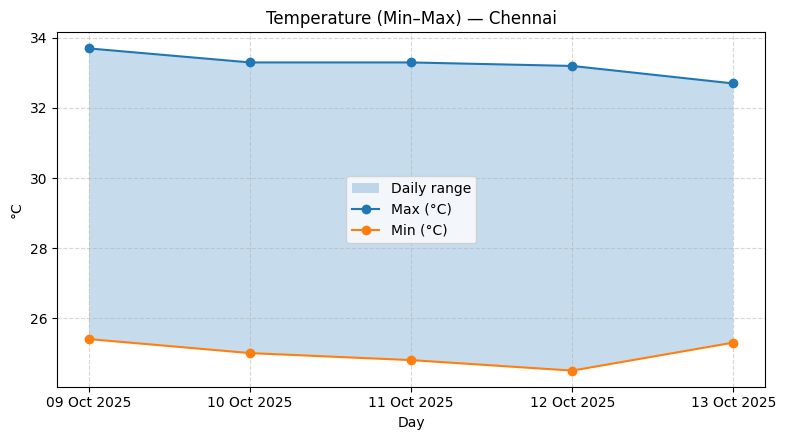

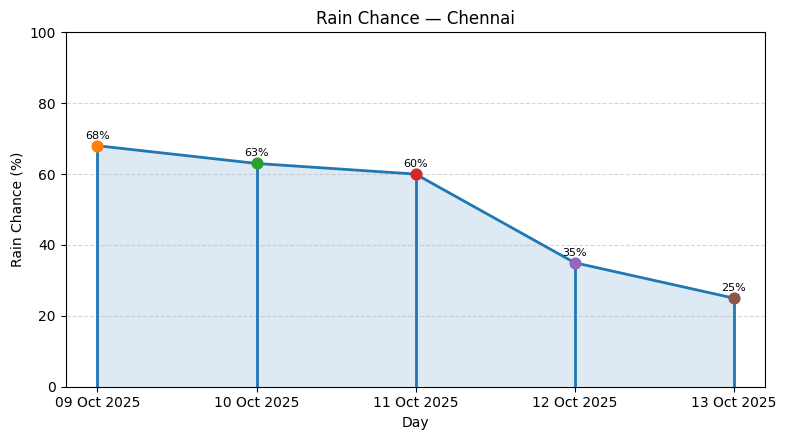


1) View Forecast  2) Ask a Question  3) Visualise  4) Exit


KeyboardInterrupt: Interrupted by user

In [15]:
4
# Questions you can ask weatherwise
SAMPLE_QUESTIONS = [
    # Rain-only
    "Will it rain today?",
    "Is rain likely in Chennai tomorrow?",

    # Temperature-only
    "Is it cold tomorrow in Melbourne?",
    "Temperature in Adelaide?",

    # General feel
    "How is the weather?",
    "Weather in Auckland in 4 days?",
]

run_app()